In [1]:

import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image,make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


In [2]:
os.makedirs('images', exist_ok=True)


n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
n_classes=10
img_size=32
channels=1
sample_interval=10000

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [  nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim+n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1)
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [5]:
adversarial_loss = torch.nn.MSELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

In [6]:
generator = Generator()
discriminator = Discriminator()

In [7]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

In [8]:
os.makedirs('data/mnist', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                        transforms.Resize(img_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

In [9]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [10]:
def sample_image( n_row,batches_done):
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row**2, latent_dim))))
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    npimg = gen_imgs.data[0].cpu().numpy()
    print(npimg[0])
    plt.imshow(npimg[0], interpolation='nearest')
    plt.show()

[Epoch 0/200] [Batch 0/938] [D loss: 0.522357] [G loss: 1.066247]


c:\program files\python36\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[[ 0.01327163 -0.02203317  0.01573314 ... -0.00923117  0.02496372
  -0.02332876]
 [-0.00827897 -0.02971535 -0.01047358 ...  0.02598744  0.00168253
  -0.01960898]
 [ 0.00823435  0.01685358 -0.02631477 ... -0.01318861  0.00183034
   0.01152145]
 ...
 [-0.00172857 -0.01823352 -0.0191024  ...  0.0271159  -0.02421811
   0.000638  ]
 [ 0.01251565 -0.00346051 -0.02650162 ... -0.00315937  0.01095702
  -0.03230277]
 [ 0.02075887 -0.0013133  -0.01487424 ... -0.01019926  0.00227038
   0.02486275]]


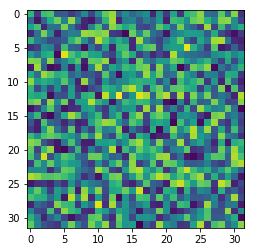

[Epoch 10/200] [Batch 620/938] [D loss: 0.155103] [G loss: 0.449606]
[[-0.99971294 -0.99999785 -0.9999848  ... -0.9999996  -1.
  -0.9999726 ]
 [-0.99999994 -0.9999997  -1.         ... -0.999984   -0.99999857
  -0.9999981 ]
 [-0.9999936  -0.9999995  -1.         ... -1.         -0.9997807
  -1.        ]
 ...
 [-0.999993   -1.         -0.99968946 ... -0.99994475 -0.9999299
  -0.9997708 ]
 [-0.99998546 -0.9985321  -0.99997693 ... -1.         -0.9999989
  -0.9969445 ]
 [-0.9999775  -0.999927   -0.99999994 ... -0.99997467 -0.9999981
  -0.9999991 ]]


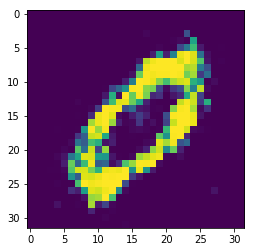

[Epoch 21/200] [Batch 302/938] [D loss: 0.222723] [G loss: 0.376962]
[[-1.         -0.99999994 -0.9999996  ... -0.99999994 -0.9998459
  -0.9997223 ]
 [-0.9999487  -0.9999856  -0.99999416 ... -0.99999326 -0.9999982
  -1.        ]
 [-1.         -0.9999956  -0.99965334 ... -0.99999964 -0.99997586
  -0.99999636]
 ...
 [-0.9999941  -0.99999934 -0.99999547 ... -0.9999993  -1.
  -1.        ]
 [-0.99999994 -0.9999963  -1.         ... -0.9999995  -0.99999803
  -1.        ]
 [-0.9999998  -0.9999953  -1.         ... -0.99999994 -0.99999976
  -0.99999774]]


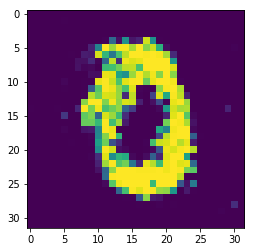

[Epoch 31/200] [Batch 922/938] [D loss: 0.222230] [G loss: 0.332522]
[[-1.         -1.         -0.99999595 ... -0.99999994 -0.99999905
  -0.9999712 ]
 [-1.         -0.9999996  -1.         ... -1.         -0.99999994
  -0.9999972 ]
 [-0.99999756 -0.99997526 -1.         ... -1.         -0.999951
  -0.99999994]
 ...
 [-0.99999624 -0.99999756 -0.99999964 ... -0.9999997  -0.99999976
  -1.        ]
 [-0.99999505 -1.         -0.99999994 ... -1.         -1.
  -0.9999998 ]
 [-0.9999034  -0.99999994 -1.         ... -0.9999997  -0.9999998
  -0.9999994 ]]


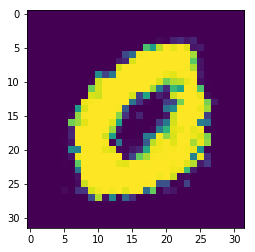

[Epoch 42/200] [Batch 604/938] [D loss: 0.232477] [G loss: 0.252160]
[[-0.9999797  -1.         -0.9999995  ... -1.         -0.9999828
  -0.9999993 ]
 [-1.         -0.99999887 -1.         ... -0.9999996  -1.
  -0.9999654 ]
 [-0.99999994 -1.         -0.99999994 ... -1.         -1.
  -1.        ]
 ...
 [-1.         -0.9999999  -1.         ... -0.99999696 -1.
  -0.99999994]
 [-0.9999996  -0.99999964 -0.99999684 ... -1.         -0.9999998
  -0.9999972 ]
 [-1.         -0.9999988  -1.         ... -0.99999994 -1.
  -1.        ]]


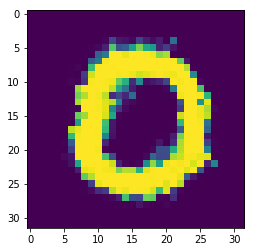

[Epoch 53/200] [Batch 286/938] [D loss: 0.219346] [G loss: 0.330595]
[[-0.9998324  -0.999932   -0.99999386 ... -0.99998313 -0.99993664
  -0.9873328 ]
 [-0.99998635 -0.9999993  -1.         ... -0.99999994 -0.9994771
  -0.9990936 ]
 [-0.99959034 -0.99999976 -0.99999636 ... -0.9979901  -0.9999989
  -0.9999498 ]
 ...
 [-0.9999992  -0.99999624 -0.9999637  ... -0.9992877  -0.99998176
  -0.99999976]
 [-0.99998844 -0.9998742  -0.99998844 ... -0.99999946 -0.9984276
  -0.99997437]
 [-0.9999619  -0.9965976  -0.9999987  ... -0.9999985  -0.99945027
  -0.99999994]]


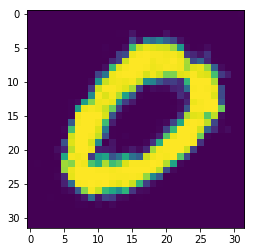

[Epoch 63/200] [Batch 906/938] [D loss: 0.213521] [G loss: 0.217879]
[[-0.999642   -0.9999971  -0.9999965  ... -0.99980086 -0.99986947
  -0.99501884]
 [-0.9998966  -0.999986   -0.99999845 ... -0.99999917 -0.9995957
  -0.99988925]
 [-0.99997693 -0.99999946 -0.9999995  ... -0.9990881  -0.99997795
  -0.9999684 ]
 ...
 [-0.99965864 -0.99998987 -0.9989067  ... -0.99998283 -0.99887866
  -0.9999938 ]
 [-0.9999248  -0.9999964  -0.9955941  ... -0.99939656 -0.9999983
  -0.99936295]
 [-0.99998385 -0.99916375 -0.999981   ... -0.99976915 -0.9996244
  -0.99999464]]


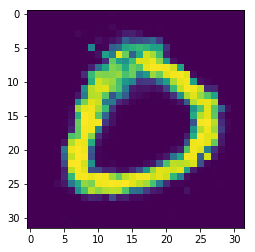

[Epoch 74/200] [Batch 588/938] [D loss: 0.161946] [G loss: 0.385216]
[[-0.99999934 -0.99998736 -0.9999888  ... -0.9962923  -0.9963387
  -0.99968016]
 [-0.99962515 -0.99984497 -0.9998924  ... -0.99987787 -0.9952173
  -0.9999343 ]
 [-0.9995194  -0.9999423  -0.9999968  ... -0.9999486  -0.9997892
  -0.9999788 ]
 ...
 [-0.9999487  -0.99996287 -0.99999416 ... -0.99981946 -0.9994821
  -0.9985214 ]
 [-0.9998951  -0.9995416  -0.99818367 ... -0.9997059  -0.9898852
  -0.9999706 ]
 [-0.99999404 -0.99984896 -0.99883425 ... -0.9991124  -0.9999286
  -0.999974  ]]


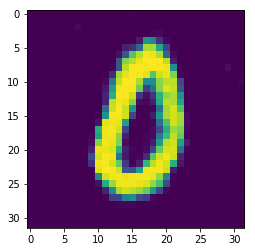

[Epoch 85/200] [Batch 270/938] [D loss: 0.131228] [G loss: 0.524418]
[[-0.99998546 -0.9999998  -0.99999887 ... -0.99999774 -0.99998903
  -0.99999964]
 [-0.99999046 -0.99999064 -0.9999999  ... -0.9999812  -0.9999833
  -0.9999689 ]
 [-0.9999989  -0.9999978  -0.99999976 ... -0.99999976 -1.
  -0.99999994]
 ...
 [-0.9999987  -0.9999997  -0.9999995  ... -0.9999813  -0.99999946
  -0.9999986 ]
 [-0.99999976 -0.99999833 -0.99999946 ... -0.99995124 -0.99999845
  -0.9999979 ]
 [-0.9999987  -0.99999946 -0.99999565 ... -0.99999994 -0.9999991
  -0.9999947 ]]


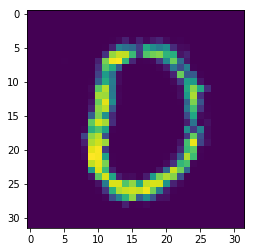

[Epoch 95/200] [Batch 890/938] [D loss: 0.133038] [G loss: 0.640880]
[[-0.9999999  -0.99996096 -0.99997586 ... -0.99999076 -0.99999875
  -0.99964464]
 [-0.99999726 -0.99991816 -0.9999842  ... -0.99938285 -0.99873793
  -0.99998313]
 [-0.9999999  -0.9999786  -0.99999565 ... -0.99997956 -0.99978805
  -0.9999909 ]
 ...
 [-0.9999486  -0.99999654 -0.9999963  ... -0.999981   -0.9997808
  -0.9994385 ]
 [-0.99974245 -0.9990781  -0.9999904  ... -0.9999807  -0.99814445
  -0.9988479 ]
 [-0.9999694  -0.99943525 -0.9999613  ... -0.99944854 -0.9999884
  -0.99996215]]


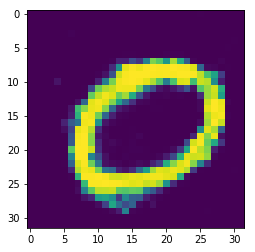

[Epoch 106/200] [Batch 572/938] [D loss: 0.112595] [G loss: 0.613837]
[[-0.99960923 -0.9998573  -0.999776   ... -0.9971102  -0.9999547
  -0.9982846 ]
 [-0.9999511  -0.99971604 -0.99962115 ... -0.9997549  -0.99746466
  -0.99832934]
 [-0.99996614 -0.99897873 -0.9997492  ... -0.99971586 -0.9969927
  -0.9998217 ]
 ...
 [-0.9995811  -0.9999471  -0.99251306 ... -0.9983017  -0.9994912
  -0.9993909 ]
 [-0.9865136  -0.9995986  -0.9995093  ... -0.99894994 -0.9957115
  -0.99967444]
 [-0.9976319  -0.99857223 -0.9999005  ... -0.99917763 -0.9991223
  -0.9991042 ]]


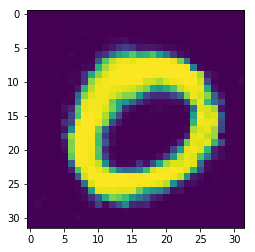

[Epoch 117/200] [Batch 254/938] [D loss: 0.107895] [G loss: 0.666675]
[[-0.9999903  -0.9998457  -0.9999016  ... -0.9999597  -0.99888724
  -0.999987  ]
 [-0.9999783  -0.9997928  -0.9999842  ... -0.99997735 -0.9999825
  -0.99995476]
 [-0.99989897 -0.99971753 -0.99994034 ... -0.999955   -0.9999544
  -0.9999997 ]
 ...
 [-0.99998665 -0.99950844 -0.9999977  ... -0.9999327  -0.99981505
  -0.9999986 ]
 [-0.99997586 -0.9999251  -0.9989742  ... -0.9995738  -0.9999987
  -0.9998575 ]
 [-0.9993112  -0.9995603  -0.9999969  ... -0.9996812  -0.99984676
  -0.9999836 ]]


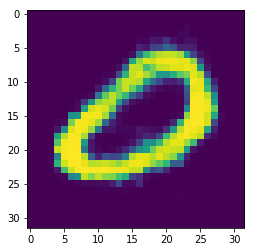

[Epoch 127/200] [Batch 874/938] [D loss: 0.142614] [G loss: 0.434870]
[[-0.9999064  -0.9999971  -0.9998986  ... -0.9999238  -0.99994844
  -0.9999825 ]
 [-0.9999836  -0.99997044 -0.99999875 ... -0.9996994  -0.99839556
  -0.99998325]
 [-0.9999923  -0.9977554  -0.99999624 ... -0.99991435 -0.99999636
  -0.99999917]
 ...
 [-0.9999845  -0.9999864  -0.9999953  ... -0.9999876  -0.9998853
  -0.99998015]
 [-0.99982405 -0.99999446 -0.9997896  ... -0.99962646 -0.9999443
  -0.9998385 ]
 [-0.99963135 -0.99996966 -0.99998516 ... -0.9999991  -0.9999328
  -0.99999833]]


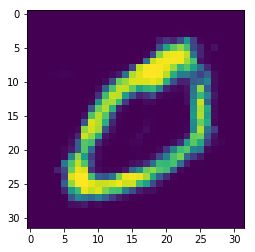

[Epoch 138/200] [Batch 556/938] [D loss: 0.081576] [G loss: 0.814665]
[[-0.99984115 -0.9996823  -0.9994826  ... -0.9997981  -0.9991828
  -0.9999291 ]
 [-0.9995302  -0.99974936 -0.9997831  ... -0.9997605  -0.9999033
  -0.99963725]
 [-0.9999558  -0.9995819  -0.9999644  ... -0.9997835  -0.9998123
  -0.9999245 ]
 ...
 [-0.99993545 -0.99992496 -0.9998129  ... -0.99986523 -0.9997871
  -0.9996499 ]
 [-0.99819714 -0.9997801  -0.9988114  ... -0.99984527 -0.9997228
  -0.999836  ]
 [-0.9980349  -0.999903   -0.99988675 ... -0.99998873 -0.9998315
  -0.9999603 ]]


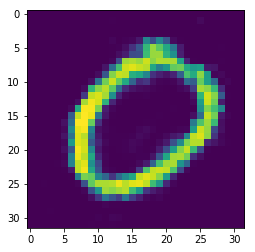

[Epoch 149/200] [Batch 238/938] [D loss: 0.102659] [G loss: 0.521351]
[[-0.99990267 -0.9999769  -0.99994016 ... -0.99986535 -0.99836844
  -0.99992424]
 [-0.9999307  -0.9999543  -0.9999865  ... -0.9999836  -0.999939
  -0.9998592 ]
 [-0.9999913  -0.9998513  -0.99982196 ... -0.9999512  -0.99992883
  -0.9999901 ]
 ...
 [-0.9999173  -0.9986052  -0.99999696 ... -0.99872726 -0.99998015
  -0.99999106]
 [-0.99179834 -0.9999822  -0.99952567 ... -0.99989414 -0.99974835
  -0.99987763]
 [-0.99986947 -0.9990564  -0.9997262  ... -0.9999915  -0.9999895
  -0.9996891 ]]


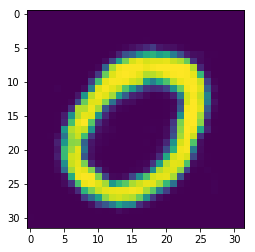

[Epoch 159/200] [Batch 858/938] [D loss: 0.074237] [G loss: 0.766936]
[[-0.9998184  -0.9999226  -0.9998763  ... -0.99991804 -0.9968841
  -0.9999686 ]
 [-0.9998807  -0.9999309  -0.99999803 ... -0.99998957 -0.9998479
  -0.9999131 ]
 [-0.9999339  -0.9994691  -0.9997064  ... -0.9998231  -0.99961257
  -0.99997866]
 ...
 [-0.99931836 -0.9957541  -0.9998849  ... -0.99839646 -0.99961764
  -0.9999311 ]
 [-0.99428165 -0.99966204 -0.9998382  ... -0.99990994 -0.9993436
  -0.9997425 ]
 [-0.99989897 -0.99961    -0.9989858  ... -0.9999584  -0.99971896
  -0.9997559 ]]


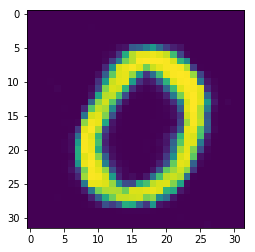

[Epoch 170/200] [Batch 540/938] [D loss: 0.079759] [G loss: 0.893323]
[[-0.9993931  -0.9997867  -0.9999898  ... -0.99997556 -0.99989575
  -0.9999974 ]
 [-0.9997967  -0.9998069  -0.99997234 ... -0.9999713  -0.9997193
  -0.9999836 ]
 [-0.99997926 -0.9990796  -0.99996907 ... -0.99994427 -0.99988616
  -0.9999976 ]
 ...
 [-0.999974   -0.9999591  -0.9999365  ... -0.9999653  -0.9999624
  -0.99994814]
 [-0.9993735  -0.99996716 -0.9998727  ... -0.9987184  -0.9993929
  -0.9998841 ]
 [-0.99978656 -0.999979   -0.99997807 ... -0.99997646 -0.999999
  -0.99998575]]


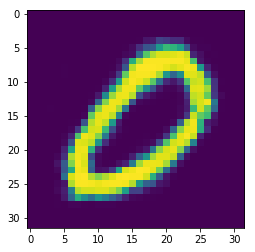

[Epoch 181/200] [Batch 222/938] [D loss: 0.208412] [G loss: 0.320063]
[[-0.9999228  -0.9971372  -0.9999447  ... -0.9898285  -0.99985176
  -0.99964553]
 [-0.99970883 -0.99994355 -0.99949825 ... -0.99997544 -0.9989774
  -0.9999418 ]
 [-0.99981755 -0.99976057 -0.99909914 ... -0.99996024 -0.9999391
  -0.99993074]
 ...
 [-0.99998355 -0.9939484  -0.99997866 ... -0.9999275  -0.9994626
  -0.9999481 ]
 [-0.9999131  -0.9995448  -0.9964353  ... -0.9992297  -0.9997035
  -0.99968034]
 [-0.99983275 -0.9998142  -0.99959654 ... -0.99999446 -0.9999528
  -0.99268085]]


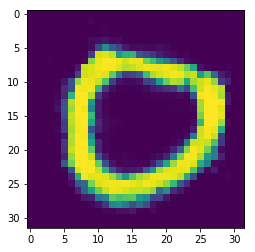

[Epoch 191/200] [Batch 842/938] [D loss: 0.087057] [G loss: 0.654227]
[[-0.9997234  -0.99999857 -0.9999988  ... -0.99999285 -0.9999298
  -0.9999977 ]
 [-0.99994665 -0.9999956  -0.99999994 ... -0.99999917 -0.9999529
  -0.99999595]
 [-0.9999351  -0.9999646  -0.99999523 ... -0.9999981  -0.99996126
  -0.9999957 ]
 ...
 [-0.9999996  -0.9999846  -0.99999964 ... -0.9999825  -0.99999577
  -0.9999993 ]
 [-0.9998447  -0.99998987 -0.999986   ... -0.9999257  -0.99999917
  -0.99983525]
 [-0.999976   -0.9999921  -0.99999946 ... -0.99999946 -0.9999998
  -0.99999255]]


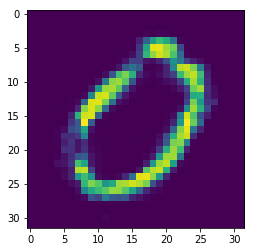

KeyboardInterrupt: 

In [11]:


for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(dataloader),d_loss.item(), g_loss.item()))
            torch.save(generator,"models/generator"+str(epoch)+"_.pt")
            sample_image(n_row=10, batches_done=batches_done)
            